# Forecasting sales of alcohol

The dataset contains 325 observations.

The main purpose of this analysis is to forecast sales of alcohol.

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()

C:\Users\Jakub\Anaconda1\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\Jakub\Anaconda1\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


# Import the data

In [3]:
df = pd.read_csv('Alcohol_Sales.csv')
df.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


# Display basic information about the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
Sales    325 non-null int64
dtypes: int64(1)
memory usage: 5.1 KB


In [6]:
df.describe()

,Sales
count,325.000000
mean,7886.400000
std,2914.269061
min,3031.000000
25%,5231.000000
50%,7481.000000
75%,9977.000000
max,15504.000000


<b>Plot the data</b>

(array([288, 348, 408, 468, 528, 588]), <a list of 6 Text xticklabel objects>)

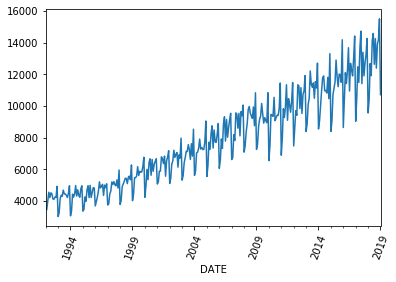

In [4]:
df.rename(columns={'S4248SM144NCEN':'Sales'}, inplace=True)
df.DATE = pd.to_datetime(df.DATE)
df.set_index('DATE', inplace=True)
df.Sales.plot()
plt.xticks(rotation=70)

Some distinguishable patterns appear when we plot the data. The time-series has an obvious seasonality pattern, as well as an overall increasing trend.

<b>Seasonal decomposing time series<b/>

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
sd = seasonal_decompose(df,freq=12)

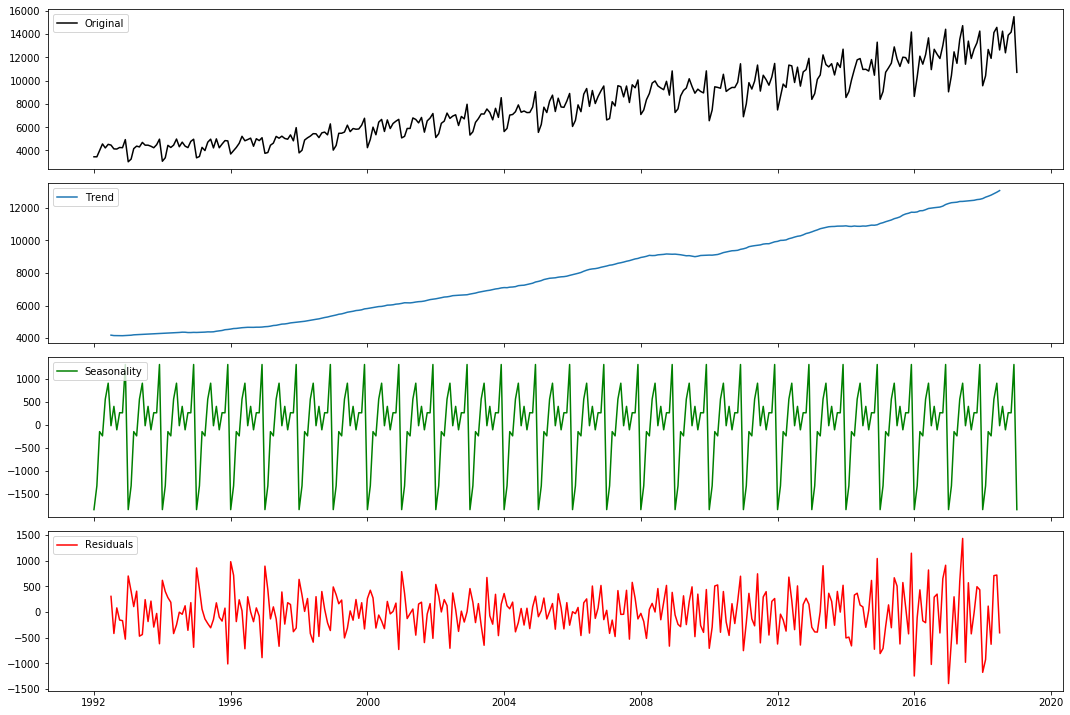

In [9]:
trend = sd.trend
seasonal = sd.seasonal
observed = sd.observed
res = sd.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False )
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(observed, 'k', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, 'g', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(res, 'r', label='Residuals')
axes[3].legend(loc='upper left')
plt.tight_layout()

We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and residuals.
    
Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. The plot above clearly shows the upwards trend of our data, along with its yearly seasonality. These can be used to understand the structure of our time-series.

<b>Time Series Analysis plot</b>

In [10]:
def tsplot(df, lags=None, style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=[10,8])
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        df.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(df, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(df, lags=lags, ax=pacf_ax, alpha=0.5)
        stats.probplot(df['Sales'], plot=qq_ax)
        month_plot(df,  ax=pp_ax)
        pp_ax.set_title('Month Plot')
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

       
    return 

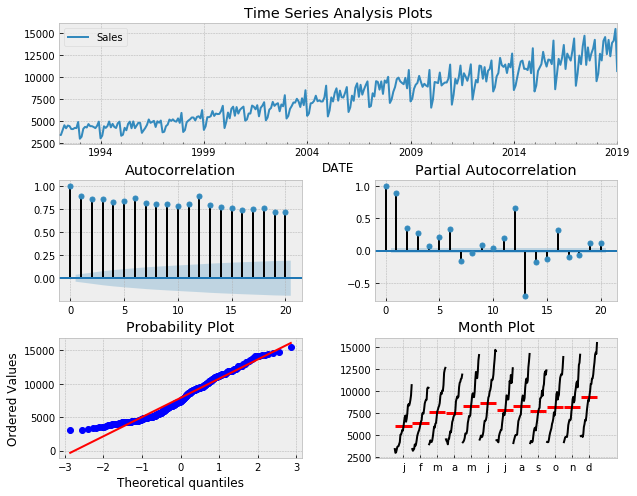

In [11]:
_ = tsplot(df, lags=20)

The autocorrelation (ACF) and partial autocorrelation (PACF) plots  indicate significant serial correlation. Below that we can see the Probability Plot, which compares the distribution of our data with another theoretical distribution. In this case probability plot indicates that the process is close to normality but with 'heavy tails'. Month plot shows that in june and december the sales was the highest.

# Modelling

In [12]:
#divide dataset into train and test sets
train = df[:312]
test = df[312:]


<b>Autoregressive Integrated Moving Average Models - ARIMA model</b>

We will use the AIC criterium to evaluate p (AR) and q (MA) orders.The level of diffrence time series we will evaluate using kpss test (stronger than ADF).

In [13]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 30, random=True, n_iter=30, test='kpss')        

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0); AIC=5329.427, BIC=5336.906, Fit time=0.005 seconds
Fit ARIMA: order=(4, 1, 4); AIC=5062.976, BIC=5100.374, Fit time=2.675 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5235.289, BIC=5250.248, Fit time=0.081 seconds
Fit ARIMA: order=(3, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=5130.423, BIC=5152.862, Fit time=0.325 seconds
Fit ARIMA: order=(4, 1, 1); AIC=5140.076, BIC=5166.255, Fit time=0.367 seconds
Fit ARIMA: order=(3, 1, 2); AIC=5133.446, BIC=5159.624, Fit time=0.501 seconds
Fit ARIMA: order=(4, 1, 3); AIC=5067.203, BIC=5100.861, Fit time=1.415 seconds
Fit ARIMA: order=(3, 1, 1); AIC=5156.553, BIC=5178.991, Fit time=0.265 seconds
Fit ARIMA: order=(1, 1, 3); AIC=5130.804, BIC=5153.243, Fit time=0.490 seconds
Fit ARIMA: order=(0, 1, 2); AIC=5154.571, BIC=5169.530, Fit time=0.086 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5154.848, BIC=5169.807, Fit time=0.078 secon

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  311
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2521.488
Method:                       css-mle   S.D. of innovations            789.125
Date:                Mon, 17 Aug 2020   AIC                           5062.976
Time:                        08:24:35   BIC                           5100.374
Sample:                             1   HQIC                          5077.924
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.3445      2.992      9.472      0.000      22.479      34.209
ar.L1.D.y      0.3375      0.124      2.722      0.007       0.094       0.580
ar.L2.D.y     -0.6325      0.105     -6.021      0.000      -0.838      -0.427
ar.L3.D.y     -0.3024      0.105     -2.885      0.004      -0.508      -0.097
ar.L4.D.y     -0.2922      0.058     -5.047      0.000      -0.406      -0.179
ma.L1.D.y     -1.3673      0.121    -11.322      0.000      -1.604      -1.131
ma.L2.D.y      1.1344      0.209      5.438      0.000       0.726       1.543
ma.L3.D.y     -0.3244      0.210     -1.544      0.124      -0.736       0.087
ma.L4.D.y     -0.3217      0.114     -2.815      0.005      -0.546      -0.098
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5155           -0.8895j            1.0281           -0.1664
AR.2            0.5155           +0.8895j            1.0281            0.1664
AR.3           -1.0331           -1.4734j            1.7995           -0.3473
AR.4           -1.0331           +1.4734j            1.7995            0.3473
MA.1            1.0801           -0.0000j            1.0801           -0.0000
MA.2            0.3945           -0.9189j            1.0001           -0.1855
MA.3            0.3945           +0.9189j            1.0001            0.1855
MA.4           -2.8774           -0.0000j            2.8774           -0.5000
-----------------------------------------------------------------------------
"""

ARIMA (4,1,4)

In [14]:
model = ARIMA(train,order=(4,1,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  311
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -2521.488
Method:                       css-mle   S.D. of innovations            789.125
Date:                Mon, 17 Aug 2020   AIC                           5062.976
Time:                        08:24:38   BIC                           5100.374
Sample:                    02-01-1992   HQIC                          5077.924
                         - 12-01-2017                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            28.3445      2.992      9.472      0.000      22.479      34.209
ar.L1.D.Sales     0.3375      0.124      2.722      0.007       0.094       0.580
ar.L2.D.Sales    -0.6325      0.105     -6.021      0.000      -0.838      -0.427
ar.L3.D.Sales    -0.3024      0.105     -2.885      0.004      -0.508      -0.097
ar.L4.D.Sales    -0.2922      0.058     -5.047      0.000      -0.406      -0.179
ma.L1.D.Sales    -1.3673      0.121    -11.322      0.000      -1.604      -1.131
ma.L2.D.Sales     1.1344      0.209      5.438      0.000       0.726       1.543
ma.L3.D.Sales    -0.3244      0.210     -1.544      0.124      -0.736       0.087
ma.L4.D.Sales    -0.3217      0.114     -2.815      0.005      -0.546      -0.098
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5155           -0.8895j            1.0281           -0.1664
AR.2            0.5155           +0.8895j            1.0281            0.1664
AR.3           -1.0331           -1.4734j            1.7995           -0.3473
AR.4           -1.0331           +1.4734j            1.7995            0.3473
MA.1            1.0801           -0.0000j            1.0801           -0.0000
MA.2            0.3945           -0.9189j            1.0001           -0.1855
MA.3            0.3945           +0.9189j            1.0001            0.1855
MA.4           -2.8774           -0.0000j            2.8774           -0.5000
-----------------------------------------------------------------------------
"""

In [15]:
start=len(train)
end=len(test)+len(train)
predictions = results.predict(start=start, end=end, typ='levels').rename('ARIMA(4,1,4) Predictions')

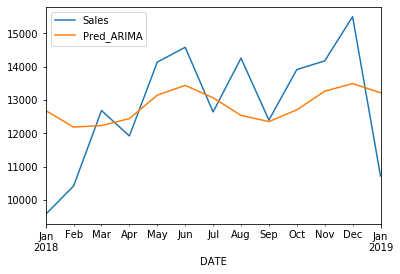

In [16]:
test['Pred_ARIMA']=predictions
test.plot(legend=True)

In [54]:
pred_arima = rmse(test['Sales'],test['Pred_ARIMA'])
RMSE = pd.Series()
RMSE['rmse_ARIMA']= pred_arima


We will use RMSE (Root Mean Square Error) to measure the error of models.

# SARIMAX

SARIMAX is similar and stands for seasonal auto regressive integrated moving average with exogenous factors. SARIMAX is used on data sets that have seasonal cycles.

In [18]:
stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=False, n_fits= 30, random=True, n_iter=30, test='kpss')        

stepwise_fit.summary()

Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=4264.290, BIC=4297.594, Fit time=7.157 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=4316.769, BIC=4346.373, Fit time=4.061 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=4323.224, BIC=4352.828, Fit time=4.263 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=4356.961, BIC=4382.864, Fit time=4.879 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=4316.823, BIC=4346.426, Fit time=4.276 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=4291.605, BIC=4332.310, Fit time=12.210 seconds
Fit ARIMA: order=(0, 1, 4) seasonal_order=(2, 1, 2, 12); AIC=4367.583, BIC=4404.587, Fit time=10.520 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(1, 1, 2, 12); AIC=4338.842, BIC=4375.846, Fit time=8.670 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4326.637, BIC=4352.540, Fit time=1.977 seconds
Fit ARIMA: order=(2, 1, 3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  312
Model:             SARIMAX(3, 1, 0)x(2, 1, 2, 12)   Log Likelihood               -2123.145
Date:                            Mon, 17 Aug 2020   AIC                           4264.290
Time:                                    08:27:55   BIC                           4297.594
Sample:                                         0   HQIC                          4277.620
                                            - 312                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1005     11.727      0.179      0.858     -20.884      25.085
ar.L1         -0.7704      0.053    -14.514      0.000      -0.874      -0.666
ar.L2         -0.5173      0.061     -8.469      0.000      -0.637      -0.398
ar.L3         -0.0587      0.057     -1.031      0.303      -0.170       0.053
ar.S.L12       0.8712      0.038     22.837      0.000       0.796       0.946
ar.S.L24      -0.9292      0.038    -24.737      0.000      -1.003      -0.856
ma.S.L12      -1.0957      0.067    -16.324      0.000      -1.227      -0.964
ma.S.L24       0.8129      0.071     11.430      0.000       0.673       0.952
sigma2      7.746e+04   6457.918     11.995      0.000    6.48e+04    9.01e+04
===================================================================================
Ljung-Box (Q):                       75.73   Jarque-Bera (JB):                12.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.40   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model1 = SARIMAX(train, order=(4,1,0) , seasonal_order=(2,1,2,12))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  312
Model:             SARIMAX(4, 1, 0)x(2, 1, 2, 12)   Log Likelihood               -2119.067
Date:                            Mon, 17 Aug 2020   AIC                           4256.133
Time:                                    08:28:02   BIC                           4289.437
Sample:                                01-01-1992   HQIC                          4269.463
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7815      0.055    -14.304      0.000      -0.889      -0.674
ar.L2         -0.6042      0.068     -8.855      0.000      -0.738      -0.470
ar.L3         -0.1862      0.072     -2.595      0.009      -0.327      -0.046
ar.L4         -0.1627      0.061     -2.656      0.008      -0.283      -0.043
ar.S.L12       0.8706      0.040     21.684      0.000       0.792       0.949
ar.S.L24      -0.9243      0.039    -23.947      0.000      -1.000      -0.849
ma.S.L12      -1.0973      0.073    -15.048      0.000      -1.240      -0.954
ma.S.L24       0.8027      0.073     11.024      0.000       0.660       0.945
sigma2      7.566e+04   6157.058     12.289      0.000    6.36e+04    8.77e+04
===================================================================================
Ljung-Box (Q):                       62.83   Jarque-Bera (JB):                22.06
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.39   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
predictions1 = results1.predict(start,end,typ='levels').rename('SARIMA Prediction')

In [21]:
test['Pred_SARIMA'] = predictions1

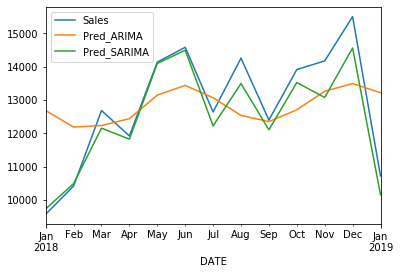

In [22]:
test.plot(legend=True)

In [55]:
pred_sarima = rmse(test['Sales'],test['Pred_SARIMA'])
RMSE['rmse_SARIMA'] =pred_sarima

# Holt-Winters’ seasonal method

The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level  ℓ, one for the trend  b, and one for the seasonal component  s, with corresponding smoothing parameters  α, β and γ. We use  m to denote the frequency of the seasonality, i.e., the number of seasons in a year.In this case for monthly data m=12.

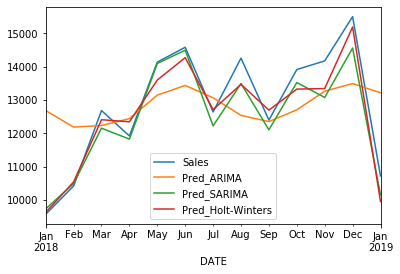

In [24]:
model2 = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit()
predictions2 = model2.forecast(13)
test['Pred_Holt-Winters'] = predictions2
test.plot(legend=True)

In [56]:
pred_holt_winters = rmse(test['Sales'],test['Pred_Holt-Winters'])
RMSE['rmse_Holt_Winters'] =pred_holt_winters

# LSTM model

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data. LSTMs can be used to model time series forecasting problems.

In [26]:
X_train = train[:round(0.8*len(train))]
X_test = train[len(X_train):]

In [27]:
(X_train.shape,X_test.shape)

((250, 1), (62, 1))

In [28]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)


In [29]:
n_features = 1
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [69]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=6)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
model.fit_generator(generator,epochs=7,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/7
238/238 [==============================] - 4s 18ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 2/7
238/238 [==============================] - 4s 19ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 3/7
238/238 [==============================] - 4s 17ms/step - loss: 0.0024 - val_loss: 0.0532
Epoch 4/7
238/238 [==============================] - 4s 18ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 5/7
238/238 [==============================] - 6s 26ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 6/7
238/238 [==============================] - 4s 18ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 7/7
238/238 [==============================] - 5s 20ms/step - loss: 0.0015 - val_loss: 7.7931e-04


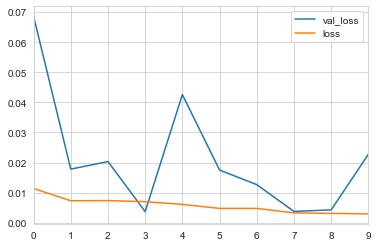

In [71]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [73]:
scaled_train_combine = scaler.fit_transform(train)

In [74]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 13

first_eval_batch = scaled_train_combine[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    
    current_pred = model.predict(current_batch)[0]
    
    
    forecast.append(current_pred) 
    
 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [75]:
forecast = scaler.inverse_transform(forecast)

In [76]:
predictions3 = pd.DataFrame(forecast, index=test.index)


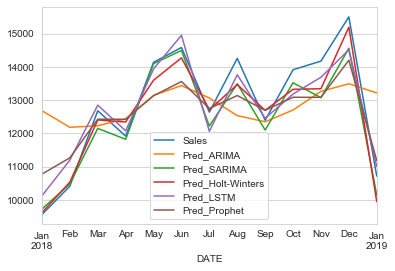

In [77]:
test['Pred_LSTM'] = predictions3
test.plot(legend=True)

In [78]:
pred_lstm = rmse(test['Sales'], test['Pred_LSTM'])
RMSE['rmse_LSTM'] =pred_lstm

# Prophet model

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [79]:
df_prophet = df.copy()

In [80]:
df_prophet.reset_index(inplace=True)
df_prophet.head()

,DATE,Sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [81]:
df_prophet.columns = ['ds','y']
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
ds    325 non-null datetime64[ns]
y     325 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


In [82]:
train_prophet = df_prophet.iloc[:312]
test_prophet = df_prophet.iloc[312:]

In [83]:
p = Prophet()
p.fit(train_prophet)
future = p.make_future_dataframe(periods=13, freq='MS')
predictions_p = p.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
prop1 = predictions_p[['ds','yhat']][-13:]

In [85]:
prop1.columns = ['DATE', 'Pred_prophet']



In [86]:
prop1 = pd.DataFrame(prop1)

In [87]:
prop1.set_index(prop1.DATE,inplace=True)

In [88]:
prop1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2018-01-01 to 2019-01-01
Data columns (total 2 columns):
DATE            13 non-null datetime64[ns]
Pred_prophet    13 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 312.0 bytes


In [89]:
test['Pred_Prophet'] = prop1['Pred_prophet']

In [90]:
pred_prophet = rmse(test['Sales'],test['Pred_Prophet'])
RMSE['rmse_Prophet'] =pred_prophet

# Forecast chart of all models

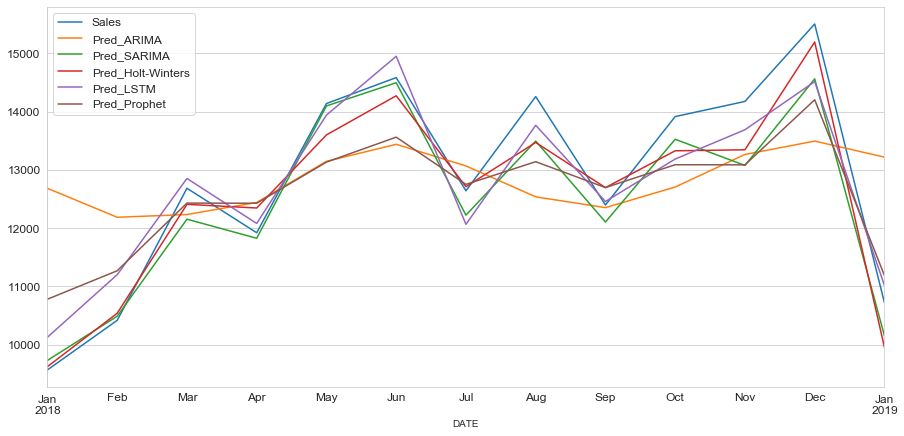

In [91]:
pd.plotting.register_matplotlib_converters()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15, 7))
test.plot(ax=ax, fontsize=12)
plt.legend(loc='best', prop={'size': 12})



# Table with models results

In [93]:
pd.DataFrame(RMSE.sort_values(ascending=True), columns=['RMSE'])

,RMSE
rmse_Holt_Winters,487.978642
rmse_LSTM,524.078181
rmse_SARIMA,536.839947
rmse_Prophet,864.240296
rmse_ARIMA,1553.120169


# Forecast chart for the best model

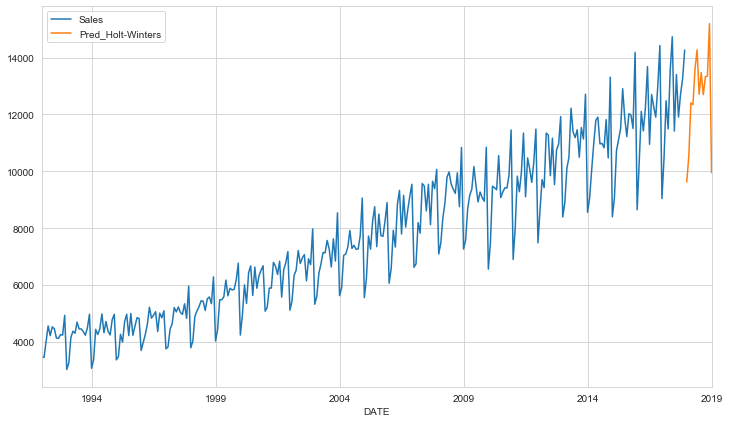

In [103]:

ax = train.plot(figsize=(12,7))
test['Pred_Holt-Winters'].plot(ax=ax)
plt.legend(loc='best')